In [1]:
import numpy as np         # v 1.19.2
from scipy import stats    # v 1.5.2
import pandas as pd        # v 1.1.3

pd.options.display.max_columns = 6
np.random.seed(123)

In [2]:
size = 10000
names, xlabels, frozen_rvs, samples = [], [], [], []

# Extract names and sane parameters of all scipy probability distributions
# (except the deprecated ones) and loop through them to create lists of names,
# frozen random variables, samples of random variates and x labels
for name, params in stats._distr_params.distcont:
    if name not in ['frechet_l', 'frechet_r']:
        loc, scale = 0, 1
        names.append(name)
        params = list(params) + [loc, scale]
        
        # Create instance of random variable
        dist = getattr(stats, name)
        
        # Create frozen random variable using parameters and add it to the list
        # to be used to draw the probability density functions
        rv = dist(*params)
        frozen_rvs.append(rv)
        
        # Create sample of random variates
        samples.append(rv.rvs(size=size))
        
        # Create x label containing the distribution parameters
        p_names = ['loc', 'scale']
        if dist.shapes:
            p_names = [sh.strip() for sh in dist.shapes.split(',')] + ['loc', 'scale']
        xlabels.append(', '.join([f'{pn}={pv:.2f}' for pn, pv in zip(p_names, params)]))

# Create pandas dataframe containing all the samples
df = pd.DataFrame(data=np.array(samples).T, columns=[name for name in names])
# Rename the duplicate column names by adding a period and an integer at the end
df.columns = pd.io.parsers.ParserBase({'names':df.columns})._maybe_dedup_names(df.columns)

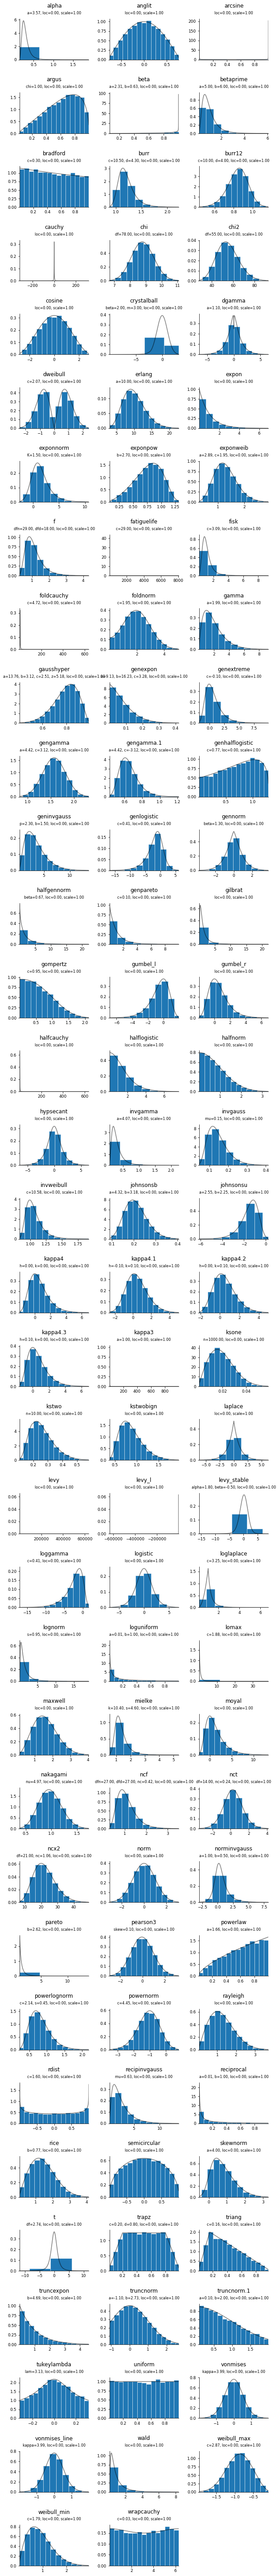

In [3]:
# Set parameters for figure dimensions
nplot = df.columns.size
cols = 3
rows = int(np.ceil(nplot/cols))
subp_w = 10/cols  # 10 corresponds to the figure width in inches
subp_h = 0.9*subp_w

# Create pandas grid of histograms
axs = df.hist(density=True, bins=15, grid=False, edgecolor='w',
              linewidth=0.5, legend=False,
              layout=(rows, cols), figsize=(cols*subp_w, rows*subp_h))

# Loop over subplots to draw probability density function and apply some
# additional formatting
for idx, ax in enumerate(axs.flat[:df.columns.size]):
    rv = frozen_rvs[idx]
    x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), size)
    ax.plot(x, rv.pdf(x), c='black', alpha=0.5)
    ax.set_title(ax.get_title(), pad=25)
    ax.set_xlim(x.min(), x.max())
    ax.set_xlabel(xlabels[idx], fontsize=8, labelpad=10)
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='both', labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax.figure.subplots_adjust(hspace=0.8, wspace=0.3)